In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import SGD
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

+ Download dữ liệu CIFAR10 sau đó chia thành 2 tập dữ liệu train và validation.
+ Chuẩn hóa dữ liệu với mean = 0.5 và std = 0.5

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, num_workers=8, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, num_workers=8, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


+ Hiển thị 5 ảnh đầu tiên trong tập dữ liệu testing

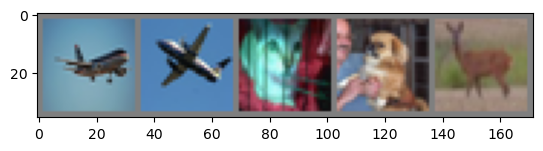

In [9]:
def imshow(img):
    img = img / 2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

for i, (images, labels) in enumerate(trainloader, 0):
    imshow(torchvision.utils.make_grid(images[:5]))
    break

+ Xây dựng model MLP cơ bản để train tập dữ liệu CIFAR10

In [10]:
def getModel(n_features):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(n_features, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)
    return model


+ Khởi tạo hàm loss function và phương thức optimizer

In [11]:
n_features = 32 * 32 * 3
model = getModel(n_features)
lr = 0.01
optim = torch.optim.AdamW(params=model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=3, gamma=0.1)
loss_fn = nn.CrossEntropyLoss()

+ Xây dựng hàm đánh giá model

In [12]:
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy


+ Bắt đầu training và đánh giá model.

In [13]:
n_epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optim.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optim.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()
    scheduler.step()
    
    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / len(trainloader)
    test_loss, test_accuracy = evaluate(model, testloader, loss_fn)
    
    print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, "
          f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/10], Loss: 1.7255, Accuracy: 39.37%, Test Loss: 1.5596, Test Accuracy: 45.77%
Epoch [2/10], Loss: 1.5019, Accuracy: 47.71%, Test Loss: 1.4956, Test Accuracy: 47.65%
Epoch [3/10], Loss: 1.4164, Accuracy: 50.68%, Test Loss: 1.4451, Test Accuracy: 49.41%
Epoch [4/10], Loss: 1.3229, Accuracy: 55.00%, Test Loss: 1.4012, Test Accuracy: 51.01%
Epoch [5/10], Loss: 1.3023, Accuracy: 55.74%, Test Loss: 1.3962, Test Accuracy: 51.26%
Epoch [6/10], Loss: 1.2922, Accuracy: 56.10%, Test Loss: 1.3911, Test Accuracy: 51.26%
Epoch [7/10], Loss: 1.2810, Accuracy: 56.67%, Test Loss: 1.3897, Test Accuracy: 51.35%
Epoch [8/10], Loss: 1.2793, Accuracy: 56.61%, Test Loss: 1.3892, Test Accuracy: 51.43%
Epoch [9/10], Loss: 1.2783, Accuracy: 56.68%, Test Loss: 1.3888, Test Accuracy: 51.41%
Epoch [10/10], Loss: 1.2770, Accuracy: 56.69%, Test Loss: 1.3888, Test Accuracy: 51.45%


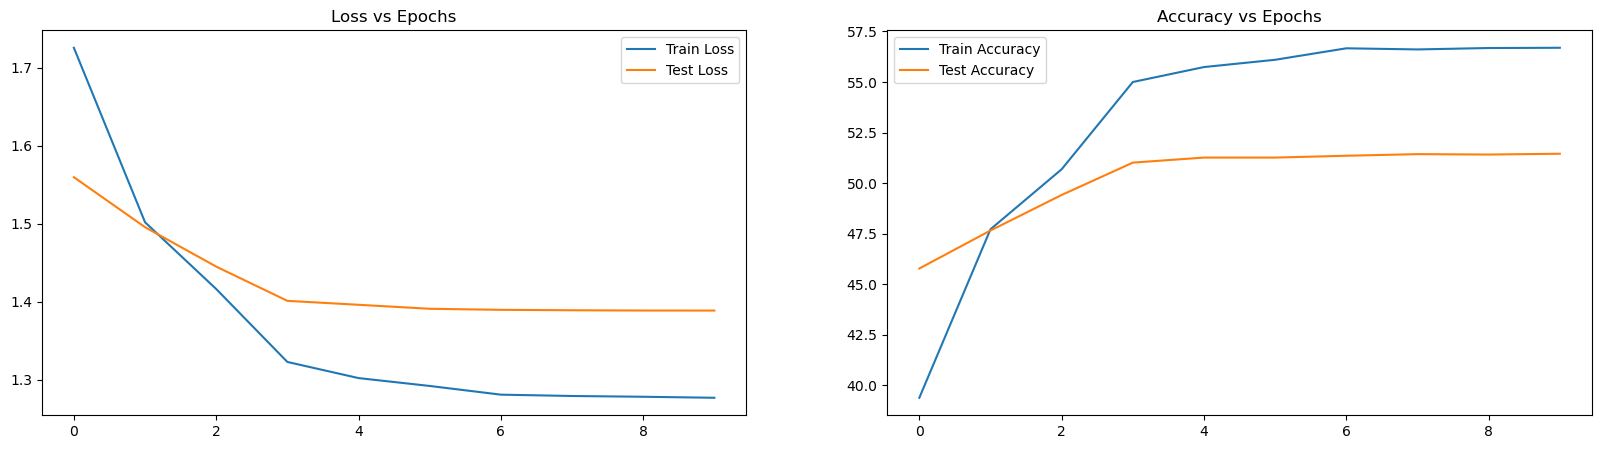

In [14]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.title('Loss vs Epochs')
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()

plt.subplot(122)
plt.title('Accuracy vs Epochs')
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.legend()

plt.show()

+ Dưới đây là bài tập về code from scratch

In [15]:
def zScoreScaling(tensor):
    mean = tensor.mean()
    std = tensor.std()
    return (tensor - mean) / std

In [16]:
def minMaxScaling(tensor):
    min_val = tensor.min()
    max_val = tensor.max()
    return (tensor - min_val) / (max_val - min_val)

In [17]:
class Linear:
    def __init__(self, in_features, out_features):
        self.weight = torch.randn(out_features, in_features) * 0.01
        self.bias = torch.zeros(out_features)

    def forward(self, input_tensor):
        return input_tensor @ self.weight.t() + self.bias
    

In [18]:
tensor = torch.tensor([
    [1.0, 2.0, 3.0], 
    [4.0, 5.0, 6.0],
    [7.0, 8.0, 9.0]
])
zscore = zScoreScaling(tensor)
min_max = minMaxScaling(tensor)
print(zscore)
print(min_max)


tensor([[-1.4606, -1.0954, -0.7303],
        [-0.3651,  0.0000,  0.3651],
        [ 0.7303,  1.0954,  1.4606]])
tensor([[0.0000, 0.1250, 0.2500],
        [0.3750, 0.5000, 0.6250],
        [0.7500, 0.8750, 1.0000]])


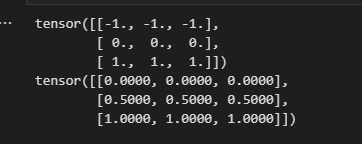

In [21]:
tensor = torch.tensor([1.0, 2.0, 3.0])
linear = Linear(3, 2)
out = linear.forward(tensor)
print(out)
print(f"Weight = {linear.weight}")
print(f"Bias = {linear.bias}")

tensor([0.0301, 0.0785])
Weight = tensor([[ 0.0023, -0.0030,  0.0113],
        [ 0.0075,  0.0190,  0.0110]])
Bias = tensor([0., 0.])


In [22]:
torch.save(model, "MLP_dress.pth")
